# 06. Model selection

In [267]:
import os
import sklearn
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from IPython.display import display

In [2]:
data = './data/'
out = './out/'

# Bold print for Jupyter Notebook
b1 = '\033[1m'
b0 = '\033[0m'

### Just some matplotlib and seaborn parameter tuning

In [3]:
axistitlesize = 20
axisticksize = 17
axislabelsize = 26
axislegendsize = 23
axistextsize = 20
axiscbarfontsize = 15

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

# Colorpalettes, colormaps, etc.
sns.set_palette(palette='rocket')

### 1. Implement a linear model

* return the weight parameters $w = \left\{ w_{1}, w_{2}, \dots , w_{p} \right\}$ and the intercept parameter $w_{0}$ separately where:

$$
\hat{y} \left( \vec{w}, \vec{x} \right)
=
w_{0} + w_{1} x_{1} + \dots + w_{p} x_{p}
$$

* check your returned coefficients with the built in `LinearRegression` class from the `sklearn` library, they should be within tolerance `1e-6`to each other

* use a generated regression dataset `from sklearn.dataset import make_regression` API with parameters `n_samples=1000` and `n_features=20`

### Generate dataset

In [6]:
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [7]:
X, y = make_regression(n_samples=1000, n_features=20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Linear regression baseline

In [35]:
# Fit the linear regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
# Get coefficients
w = lin_reg.coef_
w_0 = lin_reg.intercept_
# Get predictions
y_pred_skl = lin_reg.predict(X_test)
# Calculate difference between predicted and test values
diff_skl = y_test - y_pred_skl

### Own function to export $w$ and $w_{0}$ parameters

I've decided to write a Python class for this. In the most basic examples, regression usually based on gradient descent (at least that's what I've learned 4 years ago in my deep learning class). We

In [36]:
class linear_regression(object):
    """
    Performs linear regression with OLS method using gradient descent.
    
    Calculates the coefficients and interception parameter of a
    multivariate linear equation in the form
    
    y(w, x) = w_0 + w_1 x_1 + ... + w_n x_n
    
    while minimizing the residual sum of squares between target values
    and the predictions made using the input dataset and the current
    coefficients.
    """
    def __init__(self, lr=1e-04, iters=100000):
        self.lr = lr
        self.iters = iters

    def __cost_func(self, X, y, coef_):
        """
        Calculate the cost for OLS. Literally learned this from Andrew Ng.
        """
        return np.sum(((X @ coef_) - y)**2) / (2 * len(y))

    def __gradient_descent(self, X, y):
        """
        Performs gradient descent with OLS to get the correct coefficients
        and interception parameter for our model.
        """
        self.cost_history = np.zeros(self.iters)
        self.loss_history = np.zeros(self.iters)
        coef_ = self.coef_
        for i in range(self.iters):
            # Calculate hypothesis
            h = X @ coef_
            # Difference between hypothesis and groundtruth
            loss = h - y
            self.loss_history[i] = np.mean(loss)
            # Gradient calculation
            gradient = (X.T @ loss) / len(y)
            # Changing values of coef_ using gradient
            coef_ = coef_ - self.lr * gradient            
            # Calculate cost
            cost = self.__cost_func(X, y, coef_)
            self.cost_history[i] = cost
            #if i % 6000 == 0:
            #    print('Cost : {0}'.format(cost))
        return coef_

    def fit(self, X, y):
        """
        Fits and input dataset with X train data and y train labels
        using gradient descent.
        """
        # Number of features in the dataset
        self.dim = X.shape[1]
        # Initialize coef_ for gradient descent
        self.coef_ = np.ones(self.dim)
        # Perform gradient descent and update coef_ coeffs
        self.coef_ = self.__gradient_descent(X, y)
        self.intercept_ = np.sum(y - X @ self.coef_) / len(y)
        
    def predict(self, X):
        return X @ self.coef_ + self.intercept_

In [37]:
# Fit the linear regression
my_lin_reg = linear_regression(iters=300000)
my_lin_reg.fit(X_train, y_train)
# Get coefficients
w = my_lin_reg.coef_
w_0 = my_lin_reg.intercept_
# Get predictions
y_pred_myl = my_lin_reg.predict(X_test)
# Calculate difference between predicted and test values
diff_myl = y_test - y_pred_myl

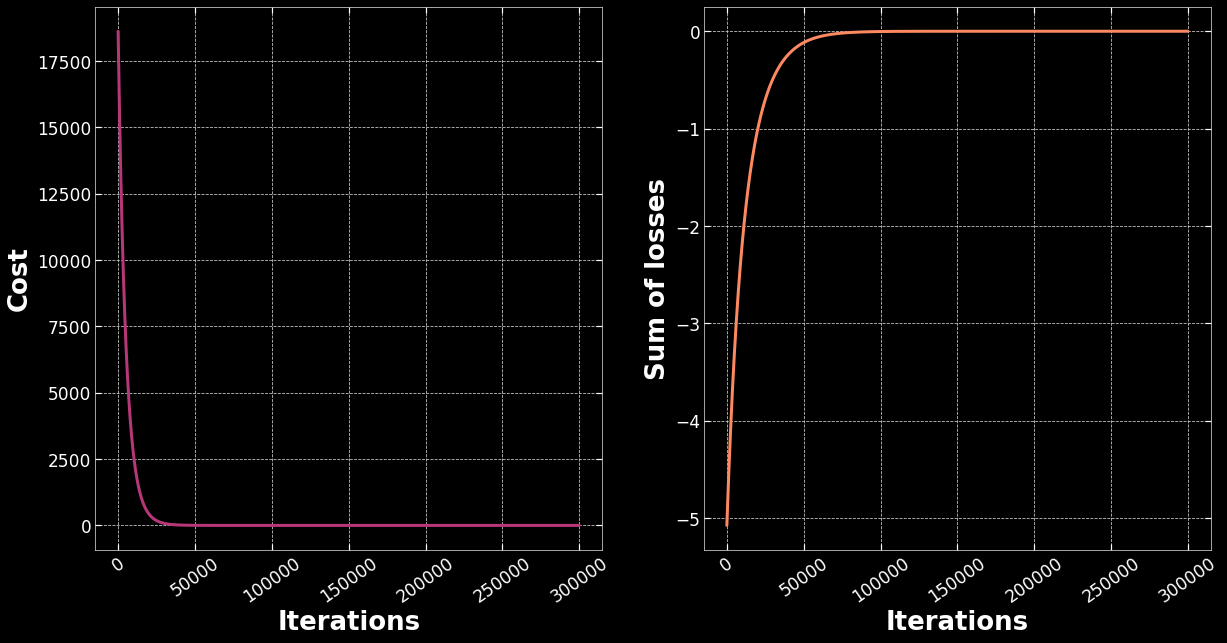

In [38]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*10, nrows*10),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})

axes[0].plot(my_lin_reg.cost_history,
          color=cm.magma(0.5), lw=3)
axes[1].plot(my_lin_reg.loss_history,
             color=cm.magma(0.75), lw=3)

y_label = ['Cost', 'Sum of losses']
for i in range(ncols):
    ax = axes[i]
    ax.set_xlabel('Iterations', fontsize=axislabelsize, fontweight='bold', color='white')
    ax.set_ylabel(y_label[i], fontsize=axislabelsize, fontweight='bold', color='white')
    ax.tick_params(axis='both', which='major', labelsize=axisticksize, colors='white')
    ax.tick_params(axis='x', which='major', rotation=35)

plt.show()

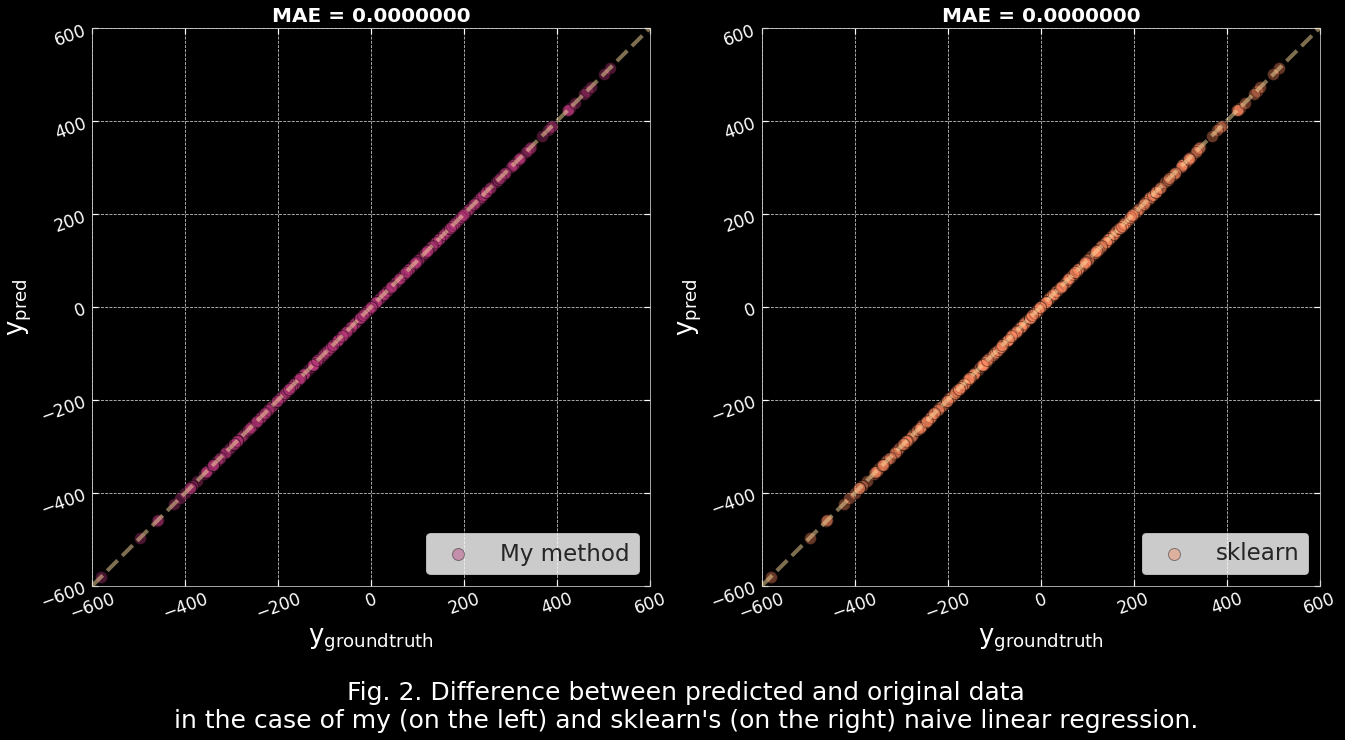

In [43]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*11, nrows*11),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})

sc = 12
ax = axes[0]
ax.scatter(y_test, y_pred_myl, label='My method',
           color=cm.magma(0.5), s=sc**2, ec='black', alpha=0.4)
ax = axes[1]
ax.scatter(y_test, y_pred_skl, label='sklearn',
           color=cm.magma(0.75), s=sc**2, ec='black', alpha=0.4)

diff = [diff_myl, diff_skl]
for i in range(ncols):
    ax = axes[i]
    ax.set_aspect('equal')

    x_lim = 600
    y_lim = 600
    ax.plot([-x_lim, x_lim], [-y_lim, y_lim],
            color=cm.magma(0.93), lw=4, ls='--', zorder=3, alpha=0.5)
    
    ax.set_xlim(-x_lim, x_lim)
    ax.set_ylim(-y_lim, y_lim)

    ax.set_title('MAE = {0:.7f}'.format(np.mean(np.abs(diff[i]))), fontsize=axistitlesize, fontweight='bold', color='white')
    ax.set_xlabel('$\mathrm{y_{groundtruth}}$', fontsize=axislabelsize, fontweight='bold', color='white')
    ax.set_ylabel('$\mathrm{y_{pred}}$', fontsize=axislabelsize, fontweight='bold', color='white')
    ax.tick_params(axis='both', which='major', rotation=20, labelsize=axisticksize, colors='white')
    
    ax.legend(loc='lower right', fontsize=axislegendsize)

fig.suptitle('Fig. 2. Difference between predicted and original data\nin the case of my (on the left) and sklearn\'s (on the right) naive linear regression.',
             color='white', fontsize=axistitlesize+5, y=0.03)

plt.show()

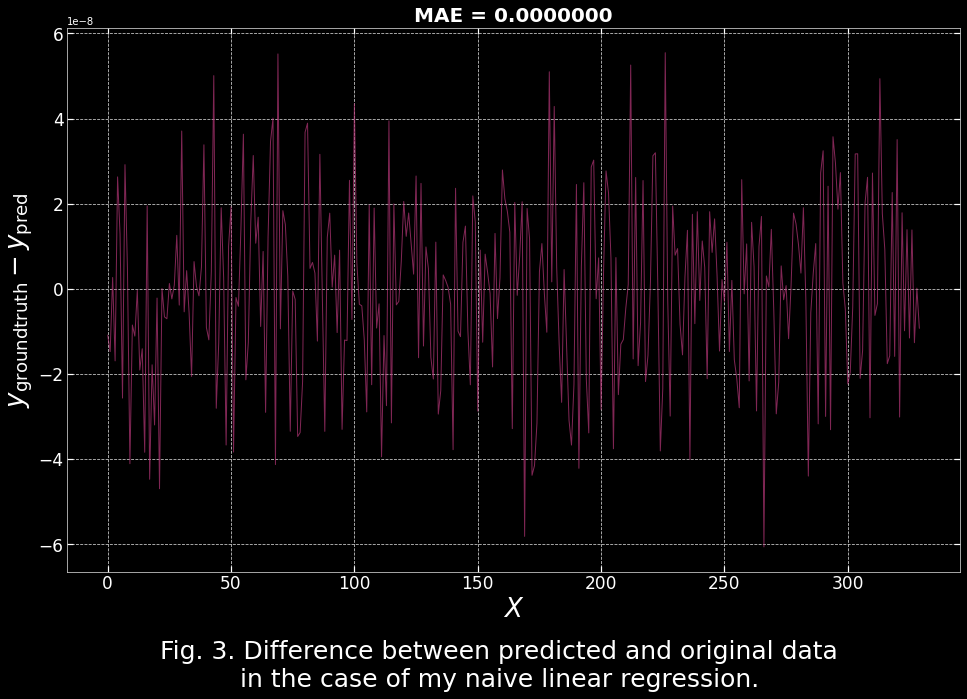

In [26]:
fig, axes = plt.subplots(figsize=(16, 10),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})

axes.plot(diff, label='Residuals',
          color=cm.magma(0.5), lw=1, alpha=0.7)

axes.set_title('MAE = {0:.7f}'.format(np.mean(np.abs(diff))), fontsize=axistitlesize, fontweight='bold', color='white')
axes.set_xlabel('$X$', fontsize=axislabelsize, fontweight='bold', color='white')
axes.set_ylabel('$y_{\mathrm{groundtruth}} - y_{\mathrm{pred}}$', fontsize=axislabelsize, fontweight='bold', color='white')
axes.tick_params(axis='both', which='major', labelsize=axisticksize, colors='white')

fig.suptitle('Fig. 3. Difference between predicted and original data\nin the case of my naive linear regression.',
             color='white', fontsize=axistitlesize+5, y=0.03)

plt.show()

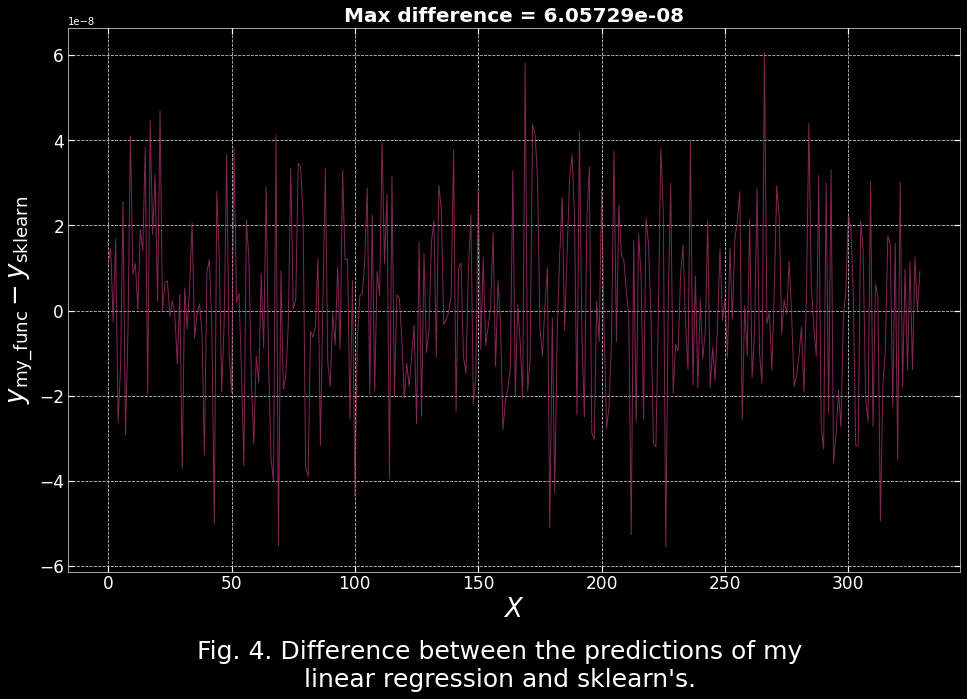

In [54]:
fig, axes = plt.subplots(figsize=(16, 10),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})

axes.plot(y_pred_myl - y_pred_skl, label='Residuals',
          color=cm.magma(0.5), lw=1, alpha=0.7)

axes.set_title('Max difference = {0:.5e}'.format(np.max(np.abs(y_pred_myl - y_pred_skl))), fontsize=axistitlesize, fontweight='bold', color='white')
axes.set_xlabel('$X$', fontsize=axislabelsize, fontweight='bold', color='white')
axes.set_ylabel('$y_{\mathrm{my\_func}} - y_{\mathrm{sklearn}}$', fontsize=axislabelsize, fontweight='bold', color='white')
axes.tick_params(axis='both', which='major', labelsize=axisticksize, colors='white')

fig.suptitle('Fig. 4. Difference between the predictions of my\nlinear regression and sklearn\'s.',
             color='white', fontsize=axistitlesize+5, y=0.03)

plt.show()

### Notes

The difference between the two estimators are below the limit of $10^{-6}$.

## 2. Use of real data

* download the [Communities and Crime Data Set](https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime) from UCI, the task includes understanding the dataset: naming the appropiate data fields, handling missing values, etc.
    
* fit a `LinearRegression` model with 5-fold cross-validation - compare training and testing scores (R^2 by default) for the different CV splits, print the mean score and its standard deviation

* find the best `Lasso` regression model with 5-fold grid search cross validation (`GridSearchCV`) on the parameters: `alpha, normalize, max_iter` and show the best parameter set

### 2./a. Load dataset

In [59]:
os.listdir(data)

['communities.data', 'communities.names']

In [60]:
features = []
# Feature names start with `@attribute`, followed by the feature name,
# then ending with the type of the feature values (numeric/string/etc.)
with open(data + 'communities.names') as f:
    while True:
        line = f.readline()
        if not line:
            break
        if '@attribute' in line.strip():
            features.append(line.strip().split(' ')[1])

In [61]:
# Missing values are marked with an `?` in the dataset
df = pd.read_csv(data + 'communities.data', sep=',', names=features, na_values=['?'])

In [62]:
display(df.head())
display(df.tail())

state  county  community        communityname  fold  population  \
0      8     NaN        NaN         Lakewoodcity     1        0.19   
1     53     NaN        NaN          Tukwilacity     1        0.00   
2     24     NaN        NaN         Aberdeentown     1        0.00   
3     34     5.0    81440.0  Willingborotownship     1        0.04   
4     42    95.0     6096.0    Bethlehemtownship     1        0.01   

   householdsize  racepctblack  racePctWhite  racePctAsian  ...  LandArea  \
0           0.33          0.02          0.90          0.12  ...      0.12   
1           0.16          0.12          0.74          0.45  ...      0.02   
2           0.42          0.49          0.56          0.17  ...      0.01   
3           0.77          1.00          0.08          0.12  ...      0.02   
4           0.55          0.02          0.95          0.09  ...      0.04   

   PopDens  PctUsePubTrans  PolicCars  PolicOperBudg  LemasPctPolicOnPatr  \
0     0.26            0.20       0.06           0.04                  0.9   
1     0.12            0.45        NaN            NaN                  NaN   
2     0.21            0.02        NaN            NaN                  NaN   
3     0.39            0.28        NaN            NaN                  NaN   
4     0.09            0.02        NaN            NaN                  NaN   

   LemasGangUnitDeploy  LemasPctOfficDrugUn  PolicBudgPerPop  \
0                  0.5                 0.32             0.14   
1                  NaN                 0.00              NaN   
2                  NaN                 0.00              NaN   
3                  NaN                 0.00              NaN   
4                  NaN                 0.00              NaN   

   ViolentCrimesPerPop  
0                 0.20  
1                 0.67  
2                 0.43  
3                 0.12  
4                 0.03  

[5 rows x 128 columns]

state  county  community      communityname  fold  population  \
1989     12     NaN        NaN  TempleTerracecity    10        0.01   
1990      6     NaN        NaN        Seasidecity    10        0.05   
1991      9     9.0    80070.0      Waterburytown    10        0.16   
1992     25    17.0    72600.0        Walthamcity    10        0.08   
1993      6     NaN        NaN        Ontariocity    10        0.20   

      householdsize  racepctblack  racePctWhite  racePctAsian  ...  LandArea  \
1989           0.40          0.10          0.87          0.12  ...      0.01   
1990           0.96          0.46          0.28          0.83  ...      0.02   
1991           0.37          0.25          0.69          0.04  ...      0.08   
1992           0.51          0.06          0.87          0.22  ...      0.03   
1993           0.78          0.14          0.46          0.24  ...      0.11   

      PopDens  PctUsePubTrans  PolicCars  PolicOperBudg  LemasPctPolicOnPatr  \
1989     0.28            0.05        NaN            NaN                  NaN   
1990     0.37            0.20        NaN            NaN                  NaN   
1991     0.32            0.18       0.08           0.06                 0.78   
1992     0.38            0.33       0.02           0.02                 0.79   
1993     0.30            0.05       0.08           0.04                 0.73   

      LemasGangUnitDeploy  LemasPctOfficDrugUn  PolicBudgPerPop  \
1989                  NaN                 0.00              NaN   
1990                  NaN                 0.00              NaN   
1991                  0.0                 0.91             0.28   
1992                  0.0                 0.22             0.18   
1993                  0.5                 1.00             0.13   

      ViolentCrimesPerPop  
1989                 0.09  
1990                 0.45  
1991                 0.23  
1992                 0.19  
1993                 0.48  

[5 rows x 128 columns]

### 2./b. Handle missing/ID labels

While missing values in meaningful features should be filled appropriately, columns representing ID-like variables can be deleted. Location and violent crime rates do correlates in real life, but an idea of a causal relationship between location and crime rates can be discarded now. Description for each feature can be accessed in the `community.names` file.

#### ID-like columns
The first 4 columns (`state`, `county`, `community`, `communityname`) can be delete, because they represent locational data.

In [63]:
df = df[features[4:]]

The column `fold` is a debug feature from cross-validation, which can be also discarded for now.

In [64]:
df = df[features[5:]]

#### Features with missing values

According to the feature descriptions, all remaining columns are in a decimal format and scaled into the inteval of $\left[ 0, 1 \right]$. The only exception is the feature `LemasGangUnitDeploy`, which is actually an ordinal with values $0.0$, $0.5$ and $1.0$. We can still however handle it as a decimal feature.

There is a table in the `community.names` description file, which summarize the basic statistical attributes (mean, median, standard deviation, etc.) of each features in the dataset. According to this table any features with missing entries have exactly $1675$ missing values in each of them. (There is only one exception, the column `OtherPerCap`, where only $1$ value is missing.). It is entirely logical to assume that in this case the missing features are always missing from the same lines. If the hypothesis is true, we can test it by visualizing the missing values on a matrixplot. If we plot features on the $y$-axis, we should see only horizontal lines (which are interrupted by vertical gaps) in the dataset, instead of individual points scattered all around the dataset.

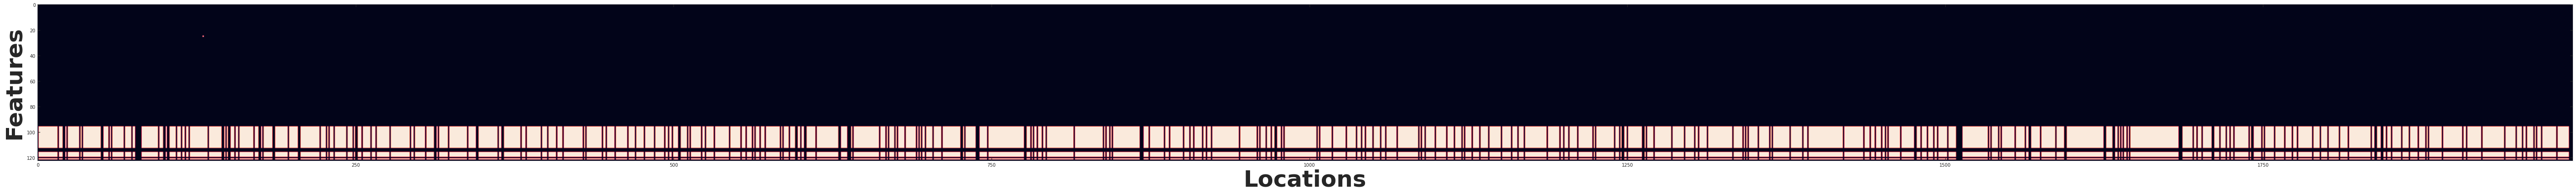

In [65]:
figsize = 100
fig, axes = plt.subplots(figsize=(figsize,figsize))
axes.set_aspect('equal')
axes.grid(False)

axes.imshow(df.isna().T)
axes.set_xlabel('Locations', fontsize=50, fontweight='bold')
axes.set_ylabel('Features', fontsize=50, fontweight='bold')

plt.show()

These are indeed "horizontal lines interrupted by vertical gaps". However these features miss most of their values. In this case we should consider simply dropping these features from the model, since filling them up with artificial values could reasonably distort the impact of these features on our model. I'll try this method in for this dataset.

In [66]:
# Drop columns with at least 50% of values missing
df_n = df.dropna(axis=1, thresh=int(0.5 * len(df)), inplace=False)

# Fill that 1 remaining entry with the mean of the corresponding feature
df_n = df_n.fillna(df_n.mean())

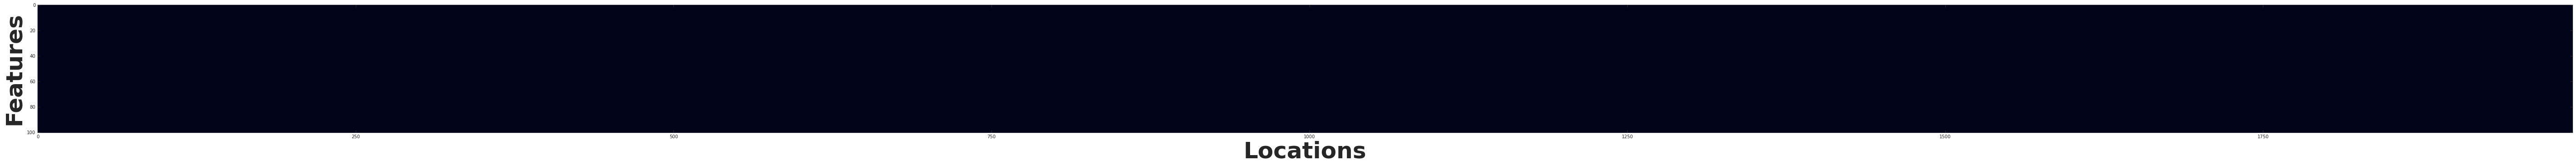

In [67]:
figsize = 100
fig, axes = plt.subplots(figsize=(figsize,figsize))
axes.set_aspect('equal')
axes.grid(False)

axes.imshow(df_n.isna().T)
axes.set_xlabel('Locations', fontsize=50, fontweight='bold')
axes.set_ylabel('Features', fontsize=50, fontweight='bold')

plt.show()

### 2./c. Fit linear regression

In [68]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [69]:
# Number of folds
folds = 5
# Invoke the KFold class from sklearn for CV tests
cv = KFold(n_splits=folds, shuffle=True, random_state=42)
# The model we use is linear regression
model = LinearRegression()

# Create the X and y datasets
X = df_n[df_n.columns[:-1]]
y = df_n[df_n.columns[-1]]

In [70]:
# Test R^2 score
# Refrence: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
scores = cross_val_score(model, X, y, scoring='r2', cv=cv)

print('KFOLD SCORES:\n' +
      '----------------')
print(scores)
print('Mean of scores : {0:.4f}'.format(np.mean(scores)))
print('Std of scores : {0:.4f}'.format(np.std(scores)))

KFOLD SCORES:
----------------
[0.6378877  0.67530393 0.63053575 0.68636242 0.6340694 ]
Mean of scores : 0.6528
Std of scores : 0.0232


### 2./d. Fit Lasso regression

In [71]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [73]:
# 5-fold search is needed
folds = 5
cv = KFold(n_splits=folds, shuffle=True, random_state=42)
# Lasso estimator
model = Lasso(random_state=None)
# Paramters to explored:
# alpha, normalize, max_iter
param_grid = {
    'alpha' : np.logspace(-10, 1, 100),
    'normalize' : [True, False],
    'max_iter' : np.logspace(4, 7, 10)
}
# Grid search cross-validation
clf = GridSearchCV(estimator=model,
                   param_grid=param_grid,
                   cv=cv,
                   n_jobs=-1)

In [74]:
best_model = clf.fit(X_train, y_train).best_estimator_
print('Best model : {0}'.format(best_model))
y_pred = best_model.predict(X_test)

Best model : Lasso(alpha=0.00021544346900318823, max_iter=10000.0)


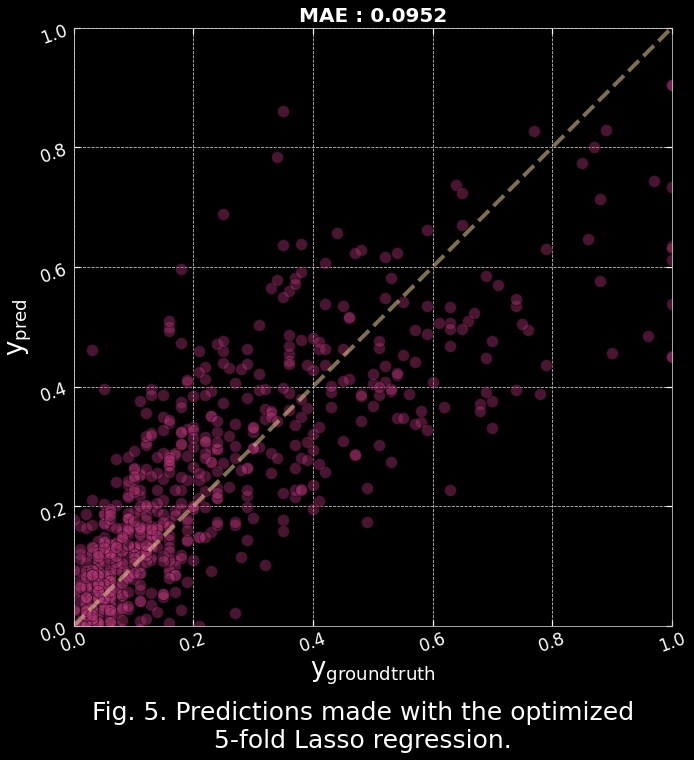

In [181]:
fig, axes = plt.subplots(figsize=(11,11),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})
axes.set_aspect('equal')

axes.plot([0, 1], [0, 1],
          color=cm.magma(0.93), lw=4, ls='--', zorder=3, alpha=0.5)

sc = 12
axes.scatter(y_test, y_pred,
             color=cm.magma(0.5), s=sc**2, ec='black', alpha=0.4)

axes.set_xlim(0, 1)
axes.set_ylim(0, 1)

axes.set_title('MAE : {0:.4f}'.format(np.mean(np.abs(y_test - y_pred))), fontsize=axistitlesize, fontweight='bold', color='white')
axes.set_xlabel('$\mathrm{y_{groundtruth}}$', fontsize=axislabelsize, fontweight='bold', color='white')
axes.set_ylabel('$\mathrm{y_{pred}}$', fontsize=axislabelsize, fontweight='bold', color='white')
axes.tick_params(axis='both', which='major', rotation=20, labelsize=axisticksize, colors='white')

fig.suptitle('Fig. 5. Predictions made with the optimized\n5-fold Lasso regression.',
             color='white', fontsize=axistitlesize+5, y=0.03)

plt.show()

### Notes on the results in 2./d.

The grid search always returned the a very small (almost always thes smallest) alpha value in the analysis above. This wasn't actually an error, but the indication, that a linear regression can be efficiently used in case of our dataset. ($\alpha \to 0$ is equivalent to the linear regression in the case of the Lasso regression.)

## 3. Shrinkage

* interpret Lasso model's findings based on its descriptive parameters by the shrinkage method described during the lecture (make a plot and check the names of the features that are not eliminated by the penalty parameter) on the data we have here (this is an explanatory data analysis problem, be to be creative)

* fit Ridge model and apply the shrinkage method as well, did you get what you expect?

* do you think normalization is needed here? If so, do not forget!

### 3./a. Lasso evaluation with shrinkage method

First of all, the analysis in task 2. returned, that normalization is not needed for this dataset. Thus, I'll won't normalize any data here, that's my answer on point 3.

In [286]:
def evaluate_lasso(X, y, alpha=1.0, normalize=False, max_iter=1e5):
    
    model = Lasso(alpha=alpha, normalize=normalize, max_iter=max_iter,
                  random_state=None)
    model.fit(X, y)
    
    return model

In [344]:
lasso_alphas = []
lasso_coeffs = []

for a in np.logspace(-10, 1, 100):
    lasso_alphas.append(a)
    model = evaluate_lasso(X_train, y_train, alpha=a, normalize=False, max_iter=1e5)
    lasso_coeffs.append(model.coef_)
    
lasso_alphas = np.array(lasso_alphas)
lasso_coeffs = np.array(lasso_coeffs)

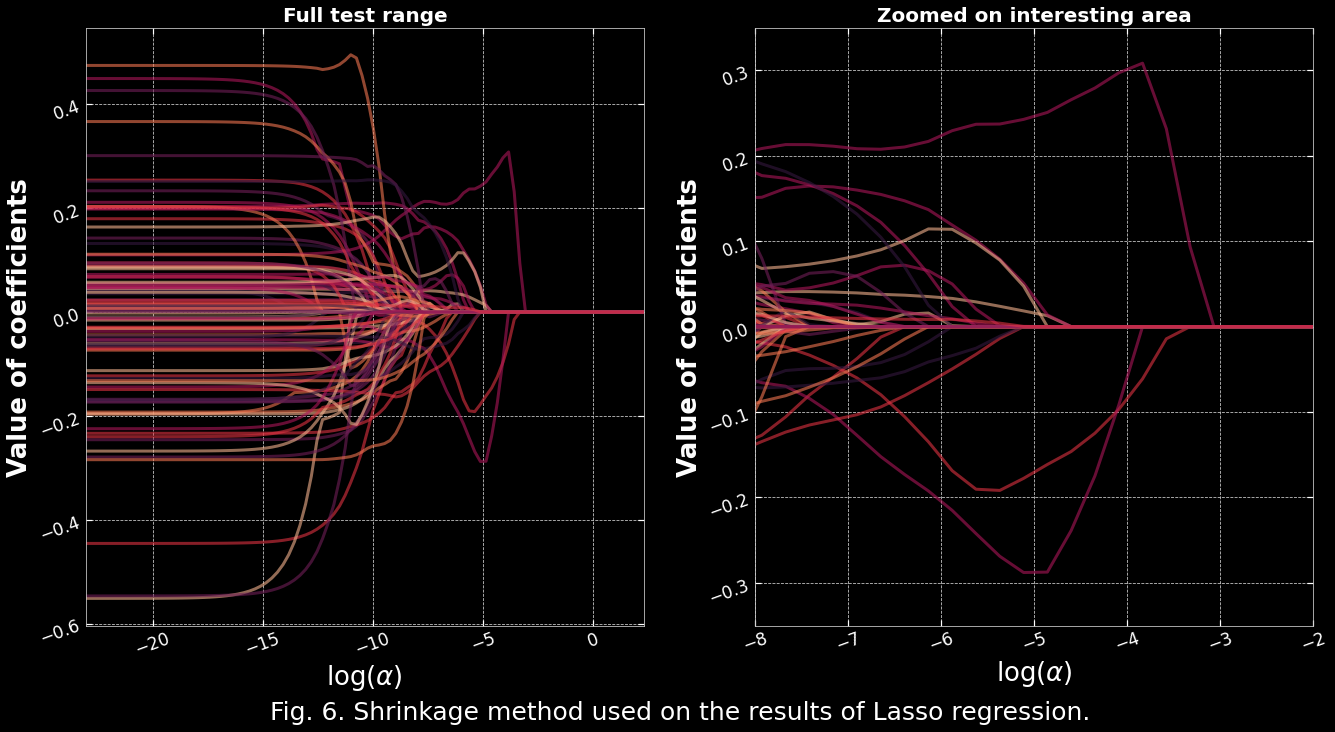

In [345]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*11,nrows*11),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})

ax = axes[0]
ax.set_xlim(np.log(lasso_alphas.min()), np.log(lasso_alphas.max()))
ax.set_title('Full test range', fontsize=axistitlesize, fontweight='bold', color='white')

ax = axes[1]
ax.set_xlim(-8,-2)
ax.set_ylim(-0.35, 0.35)
ax.set_title('Zoomed on interesting area', fontsize=axistitlesize, fontweight='bold', color='white')

for ax in axes:
    ax.plot(np.log(lasso_alphas), lasso_coeffs,
          lw=3, alpha=0.6)
    
    ax.set_xlabel('$\log \\left( \\alpha \\right)$', fontsize=axislabelsize, fontweight='bold', color='white')
    ax.set_ylabel('Value of coefficients', fontsize=axislabelsize, fontweight='bold', color='white')
    ax.tick_params(axis='both', which='major', rotation=20, labelsize=axisticksize, colors='white')

fig.suptitle('Fig. 6. Shrinkage method used on the results of Lasso regression.',
             color='white', fontsize=axistitlesize+5, y=0.03)
    
plt.show()

Around $\log \left( \alpha \right)\approx-5$ is where mostly the interesting events happen. That's the place, where a lot of coefficients diverges away from 0, while other coefficients vanish. Two other coefficients does the same, but with much a much smaller extent around $\log \left( \alpha \right) \approx -12$, before vanishing quickly. Let's see which features are responsible for this last anomalies.

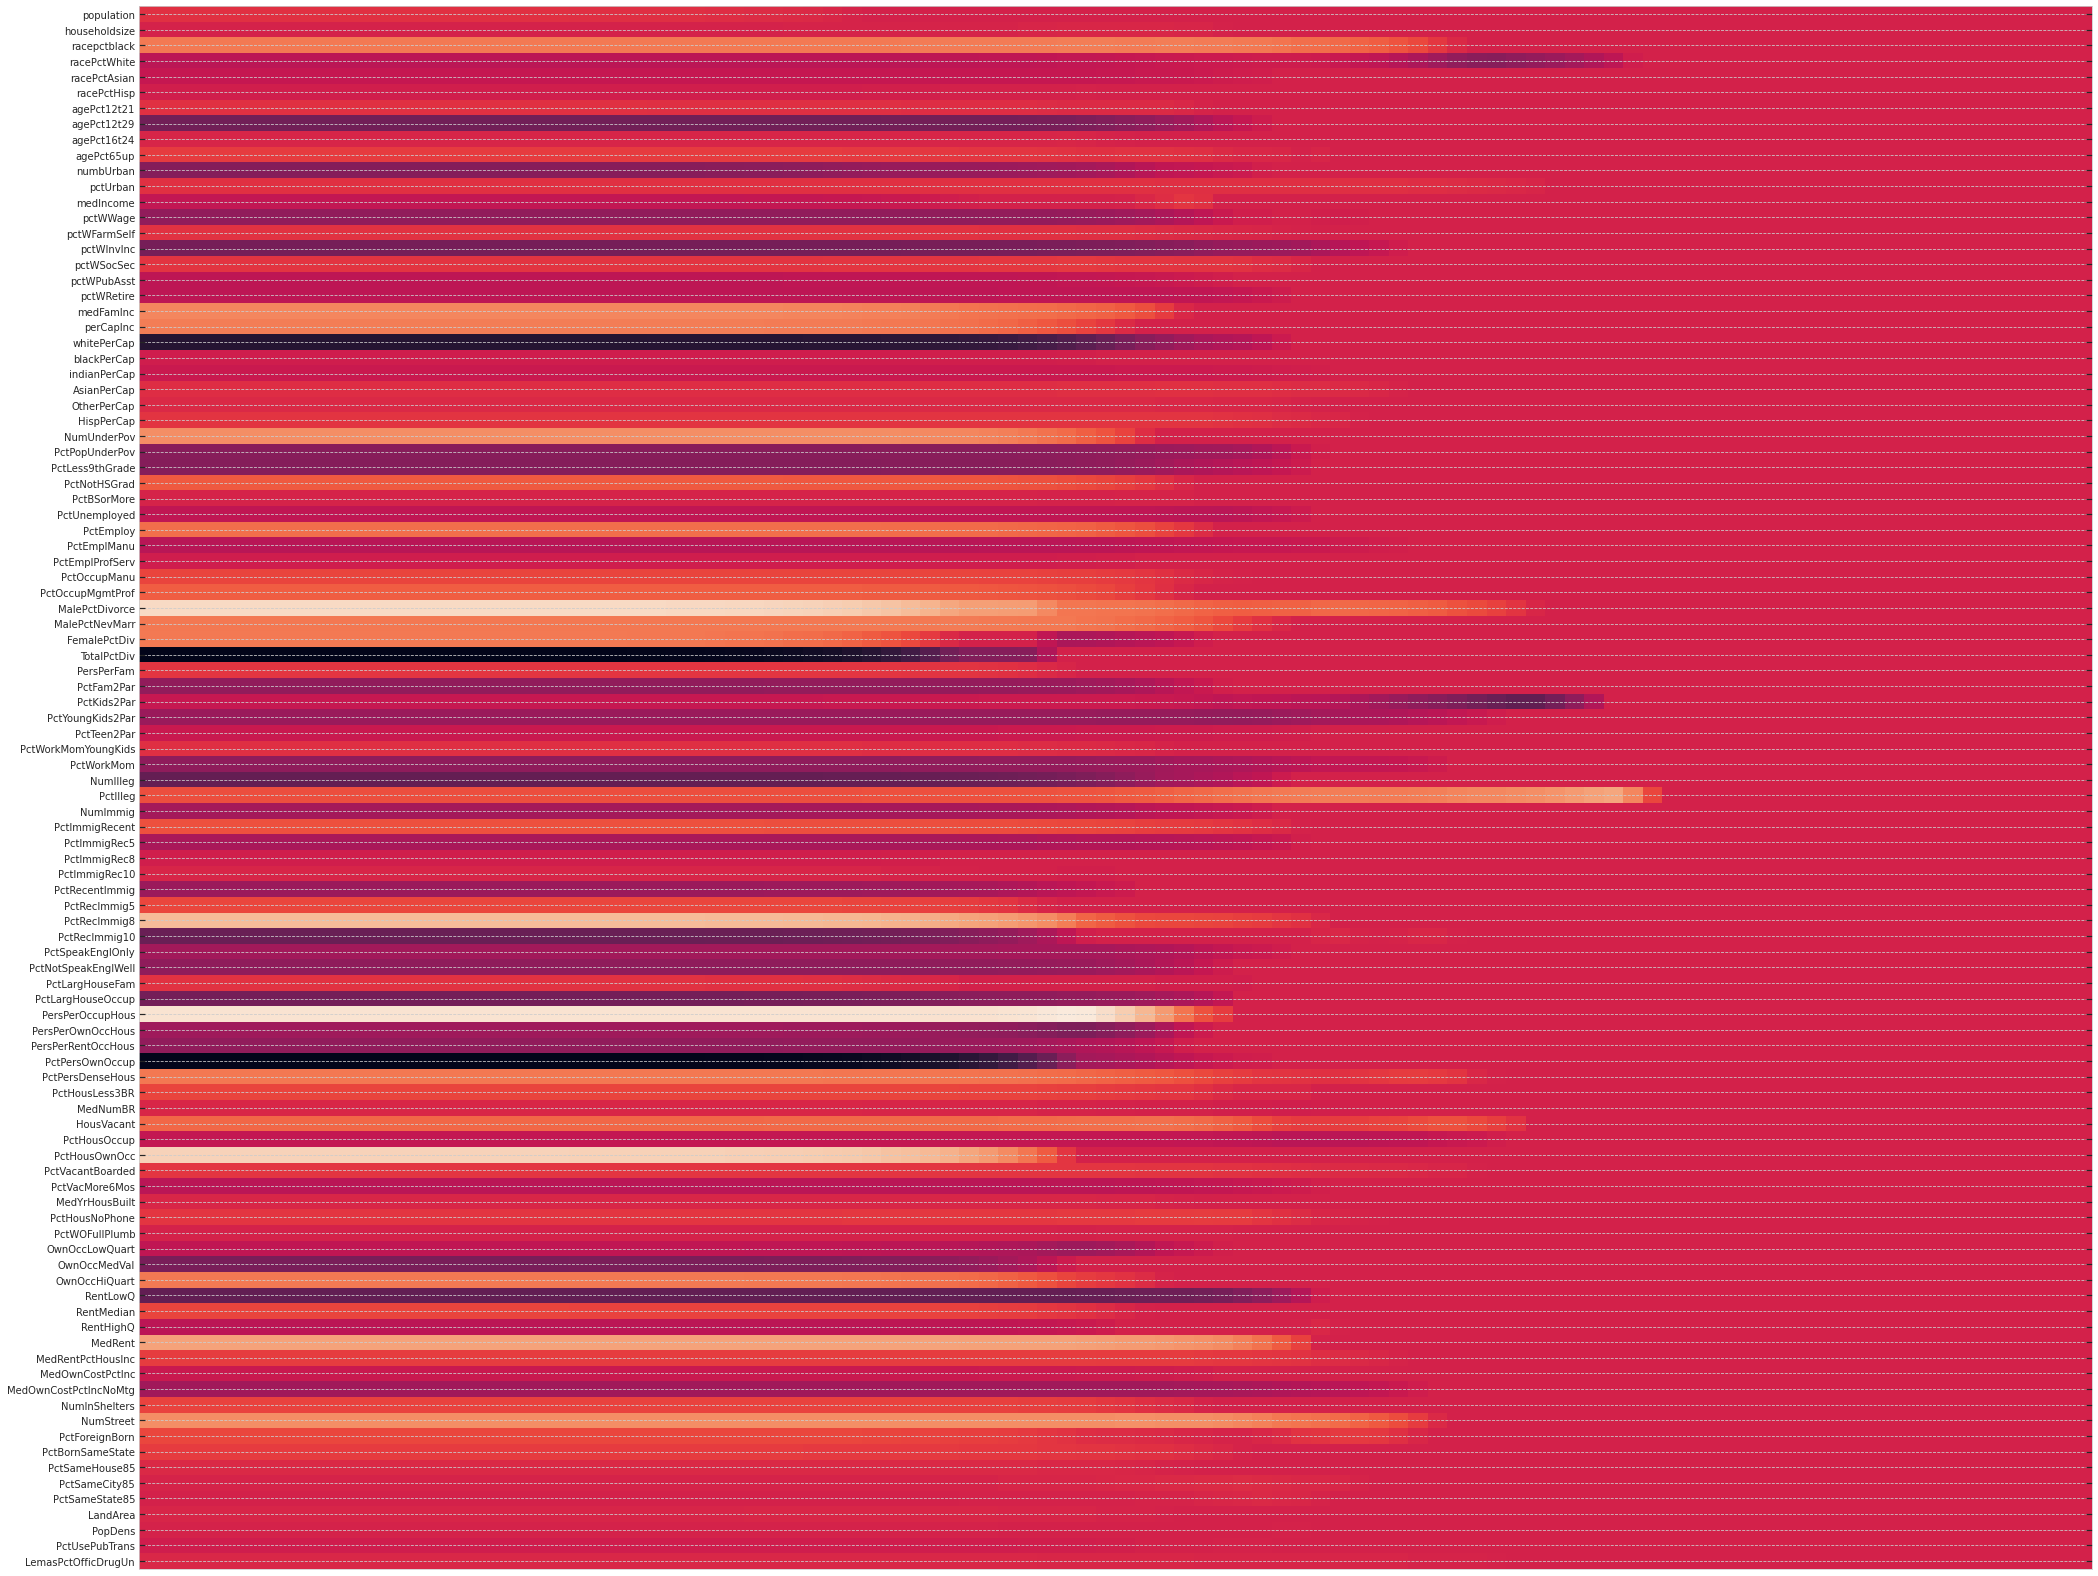

In [382]:
fig, axes = plt.subplots(figsize=(35,35))

axes.imshow(lasso_coeffs.T, aspect=0.8)

axes.set_xticks([])
axes.set_xticklabels([])

axes.set_yticks([i for i in range(len(df_n.columns[:-1]))])
axes.set_yticklabels(df_n.columns.tolist()[:-1])

plt.show()

Among the coefficients with positive impact, the winner turned out to be the `PctIlleg` feature, followed by the `MalePctDivorce`, `HouseVacant`, `racePctBlack` and `PctPersDenseHous`.

### 3./b. Ridge evaluation with shrinkage method

In [342]:
from sklearn.linear_model import Ridge

In [346]:
def evaluate_ridge(X, y, alpha=1.0, normalize=False, max_iter=1e5):
    
    model = Ridge(alpha=alpha, normalize=normalize, max_iter=max_iter,
                  random_state=None)
    model.fit(X, y)
    
    return model

In [349]:
ridge_alphas = []
ridge_coeffs = []

for a in np.logspace(-10, 10, 100):
    ridge_alphas.append(a)
    model = evaluate_ridge(X_train, y_train, alpha=a, normalize=False, max_iter=1e5)
    ridge_coeffs.append(model.coef_)
    
ridge_alphas = np.array(ridge_alphas)
ridge_coeffs = np.array(ridge_coeffs)

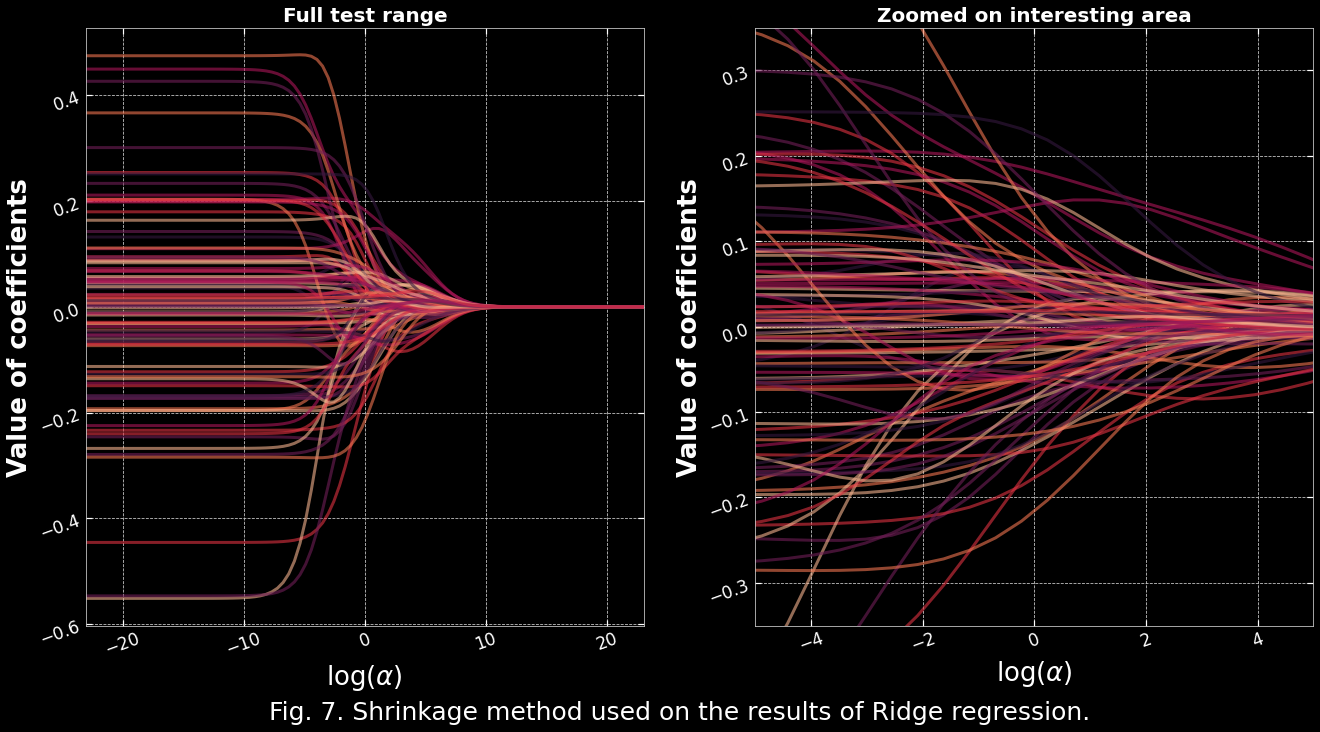

In [353]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*11,nrows*11),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})

ax = axes[0]
ax.set_xlim(np.log(ridge_alphas.min()), np.log(ridge_alphas.max()))
ax.set_title('Full test range', fontsize=axistitlesize, fontweight='bold', color='white')

ax = axes[1]
ax.set_xlim(-5, 5)
ax.set_ylim(-0.35, 0.35)
ax.set_title('Zoomed on interesting area', fontsize=axistitlesize, fontweight='bold', color='white')

for ax in axes:
    ax.plot(np.log(ridge_alphas), ridge_coeffs,
          lw=3, alpha=0.6)
    
    ax.set_xlabel('$\log \\left( \\alpha \\right)$', fontsize=axislabelsize, fontweight='bold', color='white')
    ax.set_ylabel('Value of coefficients', fontsize=axislabelsize, fontweight='bold', color='white')
    ax.tick_params(axis='both', which='major', rotation=20, labelsize=axisticksize, colors='white')

fig.suptitle('Fig. 7. Shrinkage method used on the results of Ridge regression.',
             color='white', fontsize=axistitlesize+5, y=0.03)
    
plt.show()

### Notes

That's exactly what I've waited for. If we read the documentation of `sklearn`'s `Lasso()` and `Ridge()` subroutines, we find, that `sklearn.linear_model.Lasso()` operates with `l1` regularization, while `sklearn.linear_model.Ridge()` does `l2`. For the `l2` regularization we want to get exactly these very smooth curves and decays, while `l1` tends to produce much more like sloppy/lumpy/zigzagy curves. Just like those, which we see above on Fig.6 and Fig.7.

Let's se the matrix plot above for Ridge too.

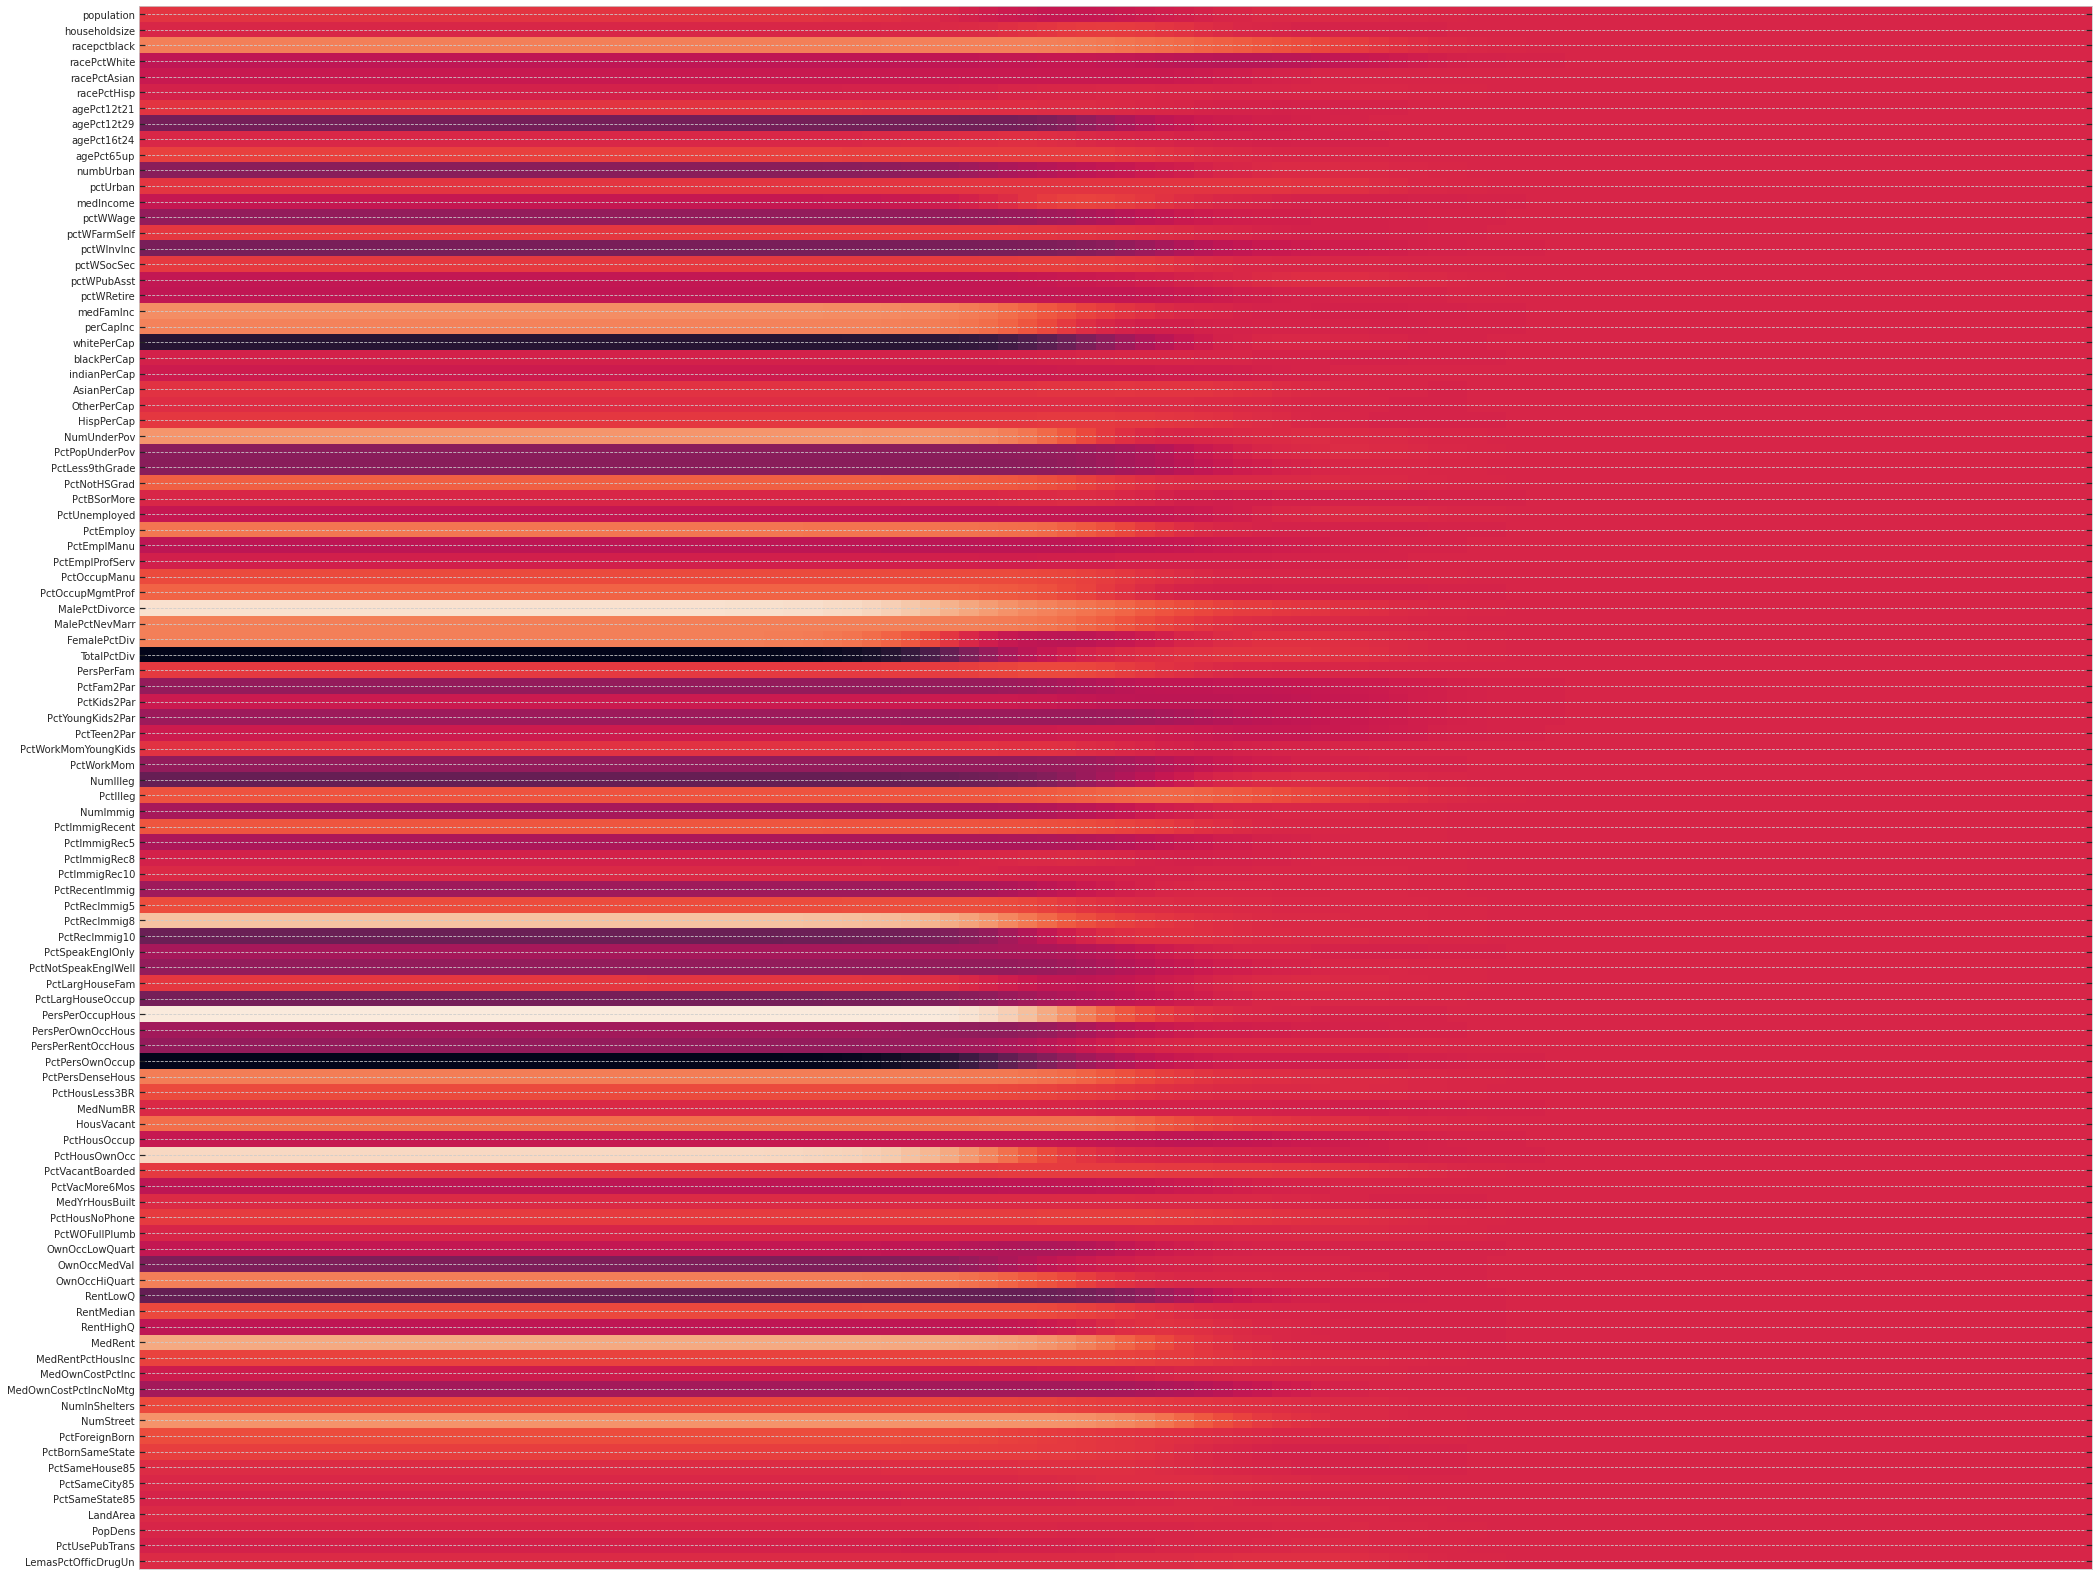

In [383]:
fig, axes = plt.subplots(figsize=(35,35))

axes.imshow(ridge_coeffs.T, aspect=0.8)

axes.set_xticks([])
axes.set_xticklabels([])

axes.set_yticks([i for i in range(len(df_n.columns[:-1]))])
axes.set_yticklabels(df_n.columns.tolist()[:-1])

plt.show()

It's almost impossible to see and analyze as easily, as one can do it with the Lasso results. I won't even try for now. Anyways, in later tasks, we'll get the same impactful features as result too.

## 4. Subset selection

* Split the data to a training and test set and do recursive feature elimination until 10 remaining predictors with 5-fold cross-validated regressors (`RidgeCV`, `LassoCV`, `ElasticNetCV`) on the training set, plot their names and look up some of their meanings (recursive feature elimination is part of `sklearn` but you can do it with a for loop if you whish).

* Do all models provide the same descriptors? Check their performance on the test set! Plot all model predictions compared to the `y_test` on 3 different plots, which model seems to be the best?

In [86]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

#### Sources

- Helpful code snippets from : https://towardsdatascience.com/a-comparison-of-shrinkage-and-selection-methods-for-linear-regression-ee4dd3a71f16

### 4./a. RidgeCV

In [328]:
# 5-fold search is needed
folds = 5
cv = KFold(n_splits=folds, shuffle=True, random_state=42)
# Create RidgeCV model
ridge_cv = RidgeCV(normalize=True, alphas=np.logspace(-10, 1, 400), cv=cv)
# Create an RFE selection
rfe = RFE(estimator=ridge_cv, n_features_to_select=10, step=1)
# Fit the selection with the 5-fold Ridge C-V as an estimator
rfe_ridge_model = rfe.fit(X_train, y_train)
# Get predictions
ridge_prediction = rfe_ridge_model.predict(X_test)

In [329]:
# Selected features
features_sel = df_n.columns[:-1][rfe_ridge_model.support_]
coef_sel = rfe_ridge_model.estimator_.coef_
# Sort them by coef_
coef_sel, features_sel = zip(*sorted(zip(coef_sel, features_sel), reverse=True))
# Calculate MAE and RMS
ridge_mae = np.mean(np.abs(y_test - ridge_prediction))
ridge_rms = np.sqrt(np.mean((y_test - ridge_prediction)**2))

In [330]:
print('Ridge Regression MAE: {0:.4f}'.format(ridge_mae))
print('Ridge Regression RMS: {0:.4f}'.format(ridge_rms))
print('Most prominent features:\n'+
      '---------------------------')
[print('{0} : {1:.4f}'.format(f, c)) for (f, c) in zip(features_sel, coef_sel)];

Ridge Regression MAE: 0.0938
Ridge Regression RMS: 0.1313
Most prominent features:
---------------------------
HousVacant : 0.2504
MedRent : 0.2460
NumStreet : 0.2378
PctIlleg : 0.2292
PctPersDenseHous : 0.2048
MalePctDivorce : 0.2019
racepctblack : 0.1736
RentLowQ : -0.1869
NumIlleg : -0.2165
PctKids2Par : -0.2503


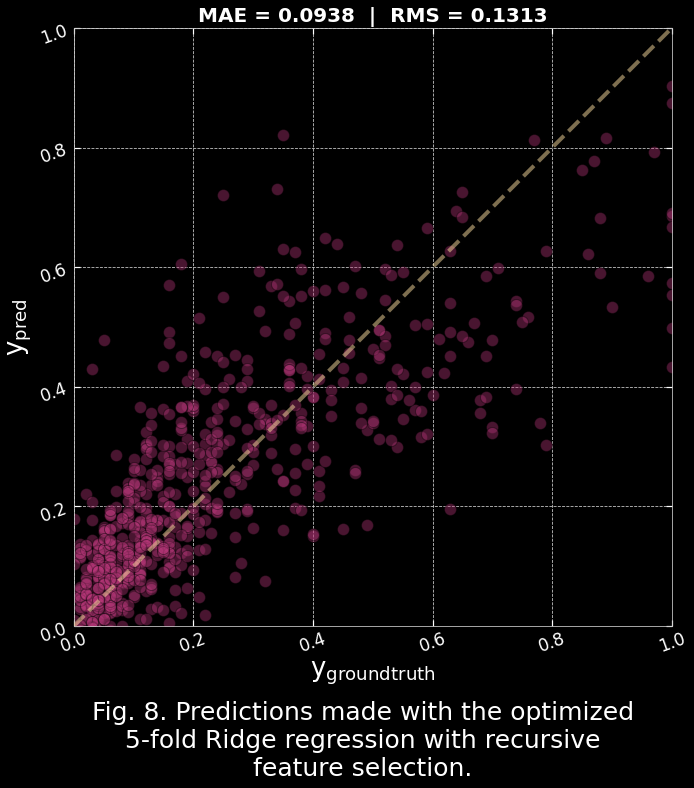

In [384]:
fig, axes = plt.subplots(figsize=(11,11),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})
axes.set_aspect('equal')

axes.plot([0, 1], [0, 1],
          color=cm.magma(0.93), lw=4, ls='--', zorder=3, alpha=0.5)

sc = 12
axes.scatter(y_test, ridge_prediction,
             color=cm.magma(0.5), s=sc**2, ec='black', alpha=0.4)

axes.set_xlim(0, 1)
axes.set_ylim(0, 1)

axes.set_title('MAE = {0:.4f}  |  RMS = {1:.4f}'.format(ridge_mae, ridge_rms),
               fontsize=axistitlesize, fontweight='bold', color='white')
axes.set_xlabel('$\mathrm{y_{groundtruth}}$', fontsize=axislabelsize, fontweight='bold', color='white')
axes.set_ylabel('$\mathrm{y_{pred}}$', fontsize=axislabelsize, fontweight='bold', color='white')
axes.tick_params(axis='both', which='major', rotation=20, labelsize=axisticksize, colors='white')

fig.suptitle('Fig. 8. Predictions made with the optimized\n5-fold Ridge regression with recursive\nfeature selection.',
             color='white', fontsize=axistitlesize+5, y=0.03)

plt.show()

### 4./b. LassoCV

In [332]:
# 5-fold search is needed
folds = 5
cv = KFold(n_splits=folds, shuffle=True, random_state=42)
# Create LassoCV model
lasso_cv = LassoCV(normalize=True, alphas=np.logspace(-10, 1, 400), max_iter=10000, cv=cv, n_jobs=-1)
# Create an RFE selection
rfe = RFE(estimator=lasso_cv, n_features_to_select=10, step=1)
# Fit the selection with the 5-fold Lasso C-V as an estimator
rfe_lasso_model = rfe.fit(X_train, y_train)
# Get predictions
lasso_prediction = rfe_lasso_model.predict(X_test)

In [333]:
# Selected features
features_sel = df_n.columns[:-1][rfe_lasso_model.support_]
coef_sel = rfe_lasso_model.estimator_.coef_
# Sort them by coef_
coef_sel, features_sel = zip(*sorted(zip(coef_sel, features_sel), reverse=True))
# Calculate MAE and RMS
lasso_mae = np.mean(np.abs(y_test - lasso_prediction))
lasso_rms = np.sqrt(np.mean((y_test - lasso_prediction)**2))

In [334]:
print('Lasso Regression MAE: {0:.4f}'.format(lasso_mae))
print('Lasso Regression RMS: {0:.4f}'.format(lasso_rms))
print('Most prominent features:\n'+
      '---------------------------')
[print('{0} : {1:.4f}'.format(f, c)) for (f, c) in zip(features_sel, coef_sel)];

Lasso Regression MAE: 0.0980
Lasso Regression RMS: 0.1375
Most prominent features:
---------------------------
PctIlleg : 0.3614
HousVacant : 0.3406
MalePctNevMarr : 0.3015
NumStreet : 0.2672
racepctblack : 0.1492
PctYoungKids2Par : -0.0843
MedOwnCostPctIncNoMtg : -0.1539
NumIlleg : -0.3462
pctWInvInc : -0.3582
agePct12t29 : -0.4377


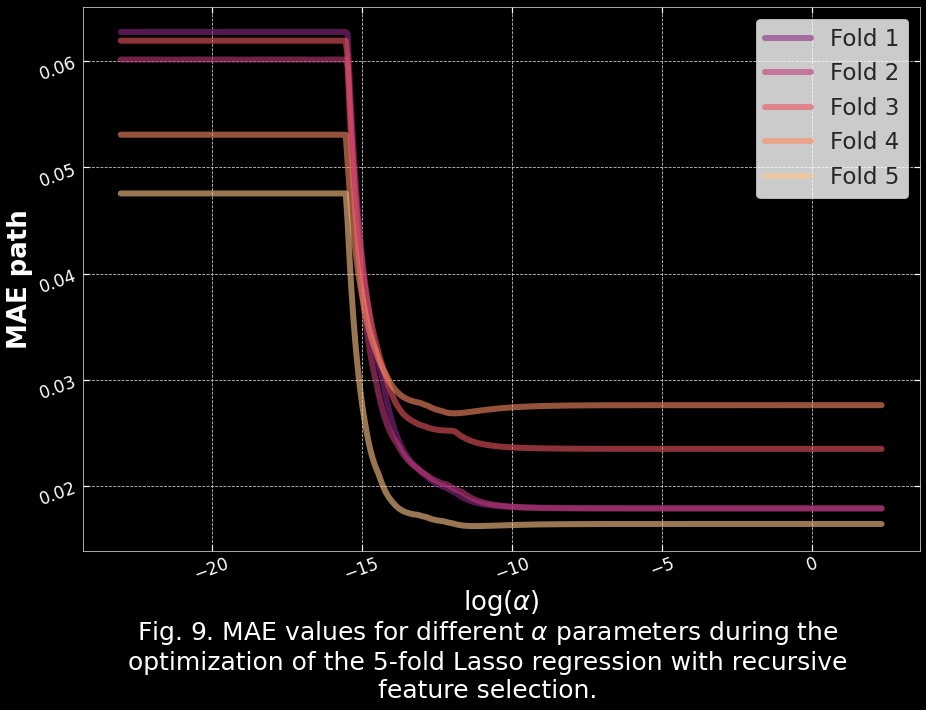

In [385]:
fig, axes = plt.subplots(figsize=(15,10),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})

colors = [cm.magma(0.4 + 0.6/folds * i) for i in range(folds)]
for i in range(folds):
    axes.plot(np.log(rfe_lasso_model.estimator_.alphas),
              rfe_lasso_model.estimator_.mse_path_[:, i],
              label='Fold {0}'.format(i+1),
              color=colors[i], lw=6, alpha=0.6)

axes.set_xlabel('$\log \\left( \\alpha \\right)$', fontsize=axislabelsize, fontweight='bold', color='white')
axes.set_ylabel('MAE path', fontsize=axislabelsize, fontweight='bold', color='white')
axes.tick_params(axis='both', which='major', rotation=20, labelsize=axisticksize, colors='white')

axes.legend(loc='upper right', fontsize=axislegendsize)

fig.suptitle('Fig. 9. MAE values for different $\\alpha$ parameters during the\n'+
             'optimization of the 5-fold Lasso regression with recursive\n'+
             'feature selection.',
             color='white', fontsize=axistitlesize+5, y=0.03)
    
plt.show()

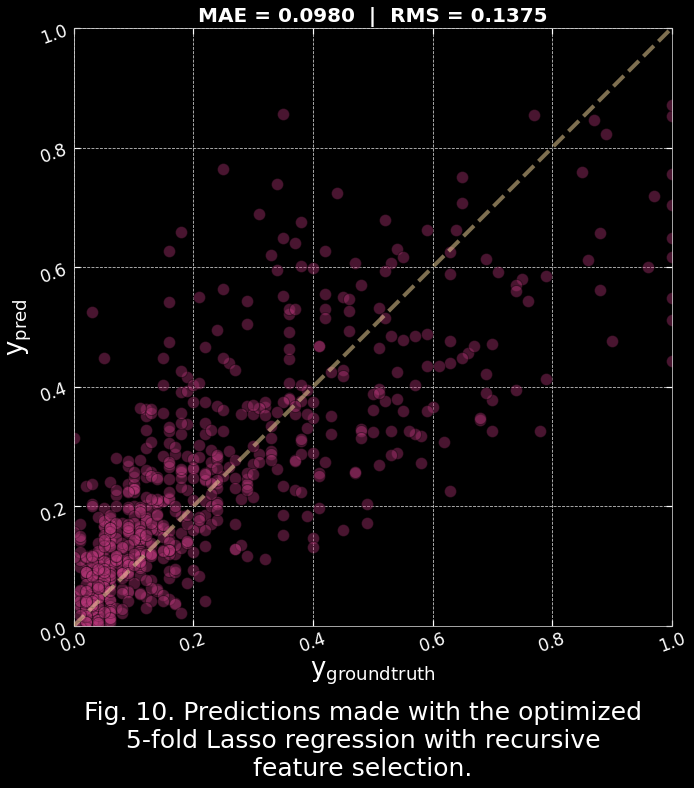

In [386]:
fig, axes = plt.subplots(figsize=(11,11),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})
axes.set_aspect('equal')

axes.plot([0, 1], [0, 1],
          color=cm.magma(0.93), lw=4, ls='--', zorder=3, alpha=0.5)

sc = 12
axes.scatter(y_test, lasso_prediction,
             color=cm.magma(0.5), s=sc**2, ec='black', alpha=0.4)

axes.set_xlim(0, 1)
axes.set_ylim(0, 1)

axes.set_title('MAE = {0:.4f}  |  RMS = {1:.4f}'.format(lasso_mae, lasso_rms),
               fontsize=axistitlesize, fontweight='bold', color='white')
axes.set_xlabel('$\mathrm{y_{groundtruth}}$', fontsize=axislabelsize, fontweight='bold', color='white')
axes.set_ylabel('$\mathrm{y_{pred}}$', fontsize=axislabelsize, fontweight='bold', color='white')
axes.tick_params(axis='both', which='major', rotation=20, labelsize=axisticksize, colors='white')

fig.suptitle('Fig. 10. Predictions made with the optimized\n5-fold Lasso regression with recursive\nfeature selection.',
             color='white', fontsize=axistitlesize+5, y=0.03)

plt.show()

### 4./c. ElasticNetCV

In [337]:
# 5-fold search is needed
folds = 5
cv = KFold(n_splits=folds, shuffle=True, random_state=42)
# Create ElasticNetCV model
elastic_net_cv = ElasticNetCV(normalize=True, alphas=np.logspace(-10, 1, 400), max_iter=10000, cv=cv, n_jobs=-1)
# Create an RFE selection
rfe = RFE(estimator=elastic_net_cv, n_features_to_select=10, step=1)
# Fit the selection with the 5-fold ElasticNet C-V as an estimator
rfe_elastic_net_model = rfe.fit(X_train, y_train)
# Get predictions
elastic_net_prediction = rfe_elastic_net_model.predict(X_test)

In [338]:
# Selected features
features_sel = df_n.columns[:-1][rfe_elastic_net_model.support_]
coef_sel = rfe_elastic_net_model.estimator_.coef_
# Sort them by coef_
coef_sel, features_sel = zip(*sorted(zip(coef_sel, features_sel), reverse=True))
# Calculate MAE and RMS
elastic_net_mae = np.mean(np.abs(y_test - elastic_net_prediction))
elastic_net_rms = np.sqrt(np.mean((y_test - elastic_net_prediction)**2))

In [339]:
print('ElasticNet Regression MAE: {0:.4f}'.format(elastic_net_mae))
print('ElasticNet Regression RMS: {0:.4f}'.format(elastic_net_rms))
print('Most prominent features:\n'+
      '---------------------------')
[print('{0} : {1:.4f}'.format(f, c)) for (f, c) in zip(features_sel, coef_sel)];

ElasticNet Regression MAE: 0.0963
ElasticNet Regression RMS: 0.1339
Most prominent features:
---------------------------
MalePctDivorce : 0.2472
HousVacant : 0.2392
NumStreet : 0.2283
PctIlleg : 0.2223
MedRent : 0.2102
racepctblack : 0.1933
numbUrban : -0.1594
RentLowQ : -0.1840
PctSpeakEnglOnly : -0.1881
PctKids2Par : -0.2289


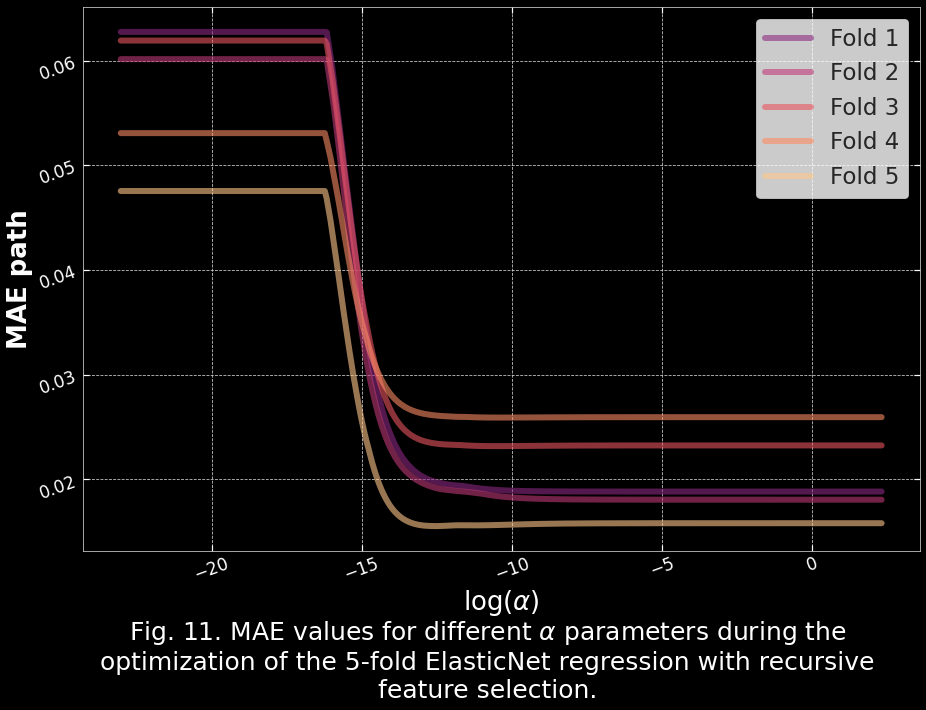

In [387]:
fig, axes = plt.subplots(figsize=(15,10),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})

colors = [cm.magma(0.4 + 0.6/folds * i) for i in range(folds)]
for i in range(folds):
    axes.plot(np.log(rfe_elastic_net_model.estimator_.alphas),
              rfe_elastic_net_model.estimator_.mse_path_[:, i],
              label='Fold {0}'.format(i+1),
              color=colors[i], lw=6, alpha=0.6)

axes.set_xlabel('$\log \\left( \\alpha \\right)$', fontsize=axislabelsize, fontweight='bold', color='white')
axes.set_ylabel('MAE path', fontsize=axislabelsize, fontweight='bold', color='white')
axes.tick_params(axis='both', which='major', rotation=20, labelsize=axisticksize, colors='white')

axes.legend(loc='upper right', fontsize=axislegendsize)

fig.suptitle('Fig. 11. MAE values for different $\\alpha$ parameters during the\n'+
             'optimization of the 5-fold ElasticNet regression with recursive\n'+
             'feature selection.',
             color='white', fontsize=axistitlesize+5, y=0.03)
    
plt.show()

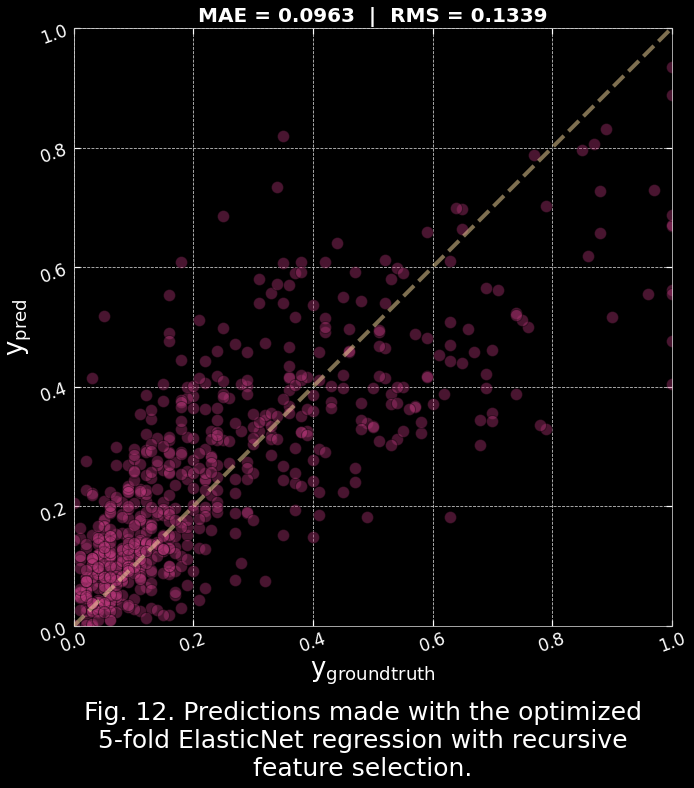

In [388]:
fig, axes = plt.subplots(figsize=(11,11),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})
axes.set_aspect('equal')

axes.plot([0, 1], [0, 1],
          color=cm.magma(0.93), lw=4, ls='--', zorder=3, alpha=0.5)

sc = 12
axes.scatter(y_test, elastic_net_prediction,
             color=cm.magma(0.5), s=sc**2, ec='black', alpha=0.4)

axes.set_xlim(0, 1)
axes.set_ylim(0, 1)

axes.set_title('MAE = {0:.4f}  |  RMS = {1:.4f}'.format(elastic_net_mae, elastic_net_rms),
               fontsize=axistitlesize, fontweight='bold', color='white')
axes.set_xlabel('$\mathrm{y_{groundtruth}}$', fontsize=axislabelsize, fontweight='bold', color='white')
axes.set_ylabel('$\mathrm{y_{pred}}$', fontsize=axislabelsize, fontweight='bold', color='white')
axes.tick_params(axis='both', which='major', rotation=20, labelsize=axisticksize, colors='white')

fig.suptitle('Fig. 12. Predictions made with the optimized\n5-fold ElasticNet regression with recursive\nfeature selection.',
             color='white', fontsize=axistitlesize+5, y=0.03)

plt.show()

### Summary

The best model seems to be Ridge, based on both the MAE and RMS scores of their predictions on the test set.

## 5. ElasticNet penalty surface

* visualize the surface of the $\mathrm{objective}(\alpha, \beta) $ parameters corresponding to the L1 and L2 regularizations. Select the best possible combination of the hyper-parameters that minimize the objective (clue: `from scipy.optimize import minimize`)
    * this task is similar to what you've seen during class, just not for MSE vs. single penalty parameter but MSE vs. two penalty parameters $\alpha, \beta$

* interpret the findings! do you think linear models are powerful enough on this dataset?

### 5./a. Explore ElasticNet with `l1` and `l2` regularization

In [416]:
from sklearn.linear_model import ElasticNet
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [417]:
@ignore_warnings(category=ConvergenceWarning)
def evaluate_elastic_net(X, y, alpha=1.0, l1_ratio=0.5, normalize=False, max_iter=1e5):
    """
    Evaluate an ElasticNet estimator with specific parameters. The goal of this function is to
    discover the penalty surface of the ElasticNet for `l1` and `l2` regularizations.
    
    `l1` and `l2` can be selected in `sklearn.linear_model.ElasticNet` with the `l1_ratio` arg
    * l1_ratio = 0 : l2
    * l1_ratio = 1 : l1
    """
    
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, normalize=normalize, max_iter=max_iter)
    model.fit(X, y)
    
    return model

#### `l1` regularization

In [407]:
elastic_net_l1_alphas = []
elastic_net_l1_coeffs = []

for a in np.logspace(-10, 0, 100):
    elastic_net_l1_alphas.append(a)
    model = evaluate_elastic_net(X_train, y_train, alpha=a, l1_ratio=1, normalize=False, max_iter=1e5)
    elastic_net_l1_coeffs.append(model.coef_)
    
elastic_net_l1_alphas = np.array(elastic_net_l1_alphas)
elastic_net_l1_coeffs = np.array(elastic_net_l1_coeffs)

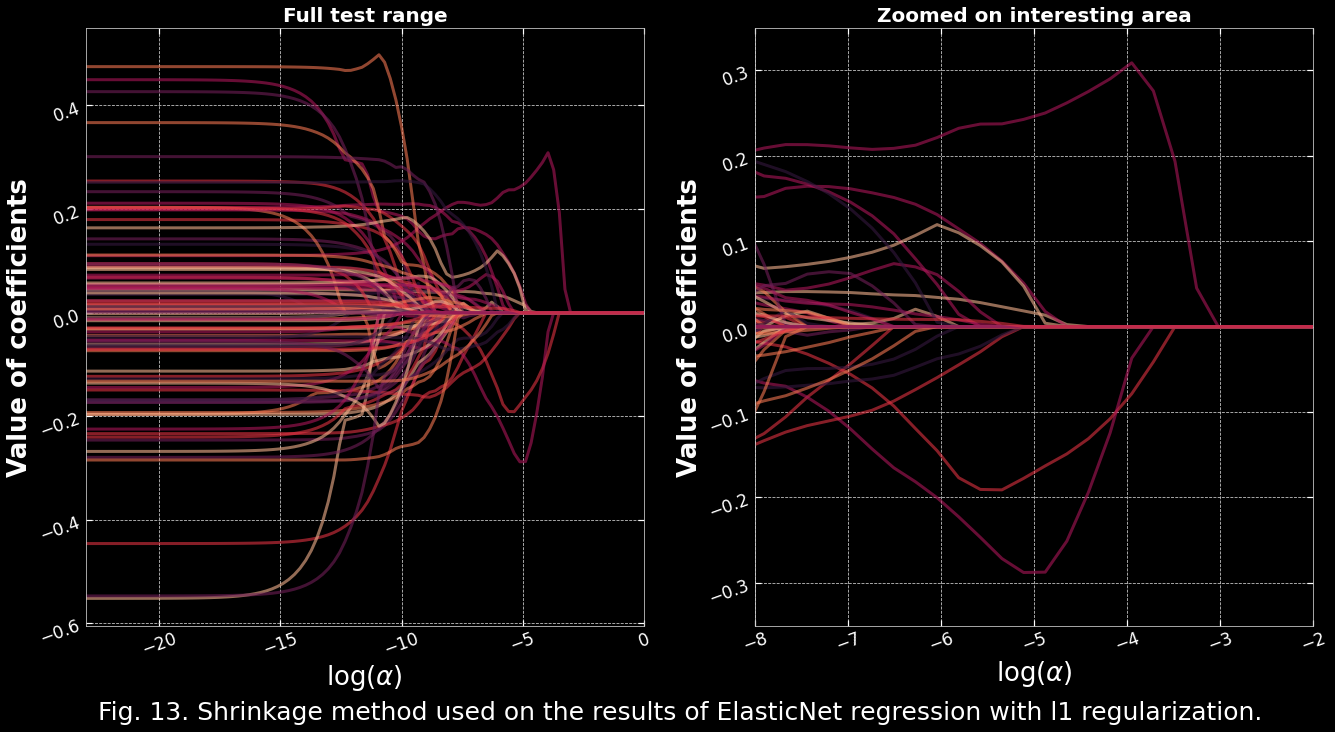

In [411]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*11,nrows*11),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})

ax = axes[0]
ax.set_xlim(np.log(elastic_net_l1_alphas.min()), np.log(elastic_net_l1_alphas.max()))
ax.set_title('Full test range', fontsize=axistitlesize, fontweight='bold', color='white')

ax = axes[1]
ax.set_xlim(-8, -2)
ax.set_ylim(-0.35, 0.35)
ax.set_title('Zoomed on interesting area', fontsize=axistitlesize, fontweight='bold', color='white')

for ax in axes:
    ax.plot(np.log(elastic_net_l1_alphas), elastic_net_l1_coeffs,
          lw=3, alpha=0.6)
    
    ax.set_xlabel('$\log \\left( \\alpha \\right)$', fontsize=axislabelsize, fontweight='bold', color='white')
    ax.set_ylabel('Value of coefficients', fontsize=axislabelsize, fontweight='bold', color='white')
    ax.tick_params(axis='both', which='major', rotation=20, labelsize=axisticksize, colors='white')

fig.suptitle('Fig. 13. Shrinkage method used on the results of ElasticNet regression with l1 regularization.',
             color='white', fontsize=axistitlesize+5, y=0.03)
    
plt.show()

#### Note

The results are very similar to what we've got from the Ridge regression in task 3.

#### `l2` regularization

In [ ]:
elastic_net_l2_alphas = []
elastic_net_l2_coeffs = []

for a in np.logspace(-10, 0, 100):
    elastic_net_l2_alphas.append(a)
    model = evaluate_elastic_net(X_train, y_train, alpha=a, l1_ratio=0, normalize=False, max_iter=1e5)
    elastic_net_l2_coeffs.append(model.coef_)

elastic_net_l2_alphas = np.array(elastic_net_l2_alphas)
elastic_net_l2_coeffs = np.array(elastic_net_l2_coeffs)

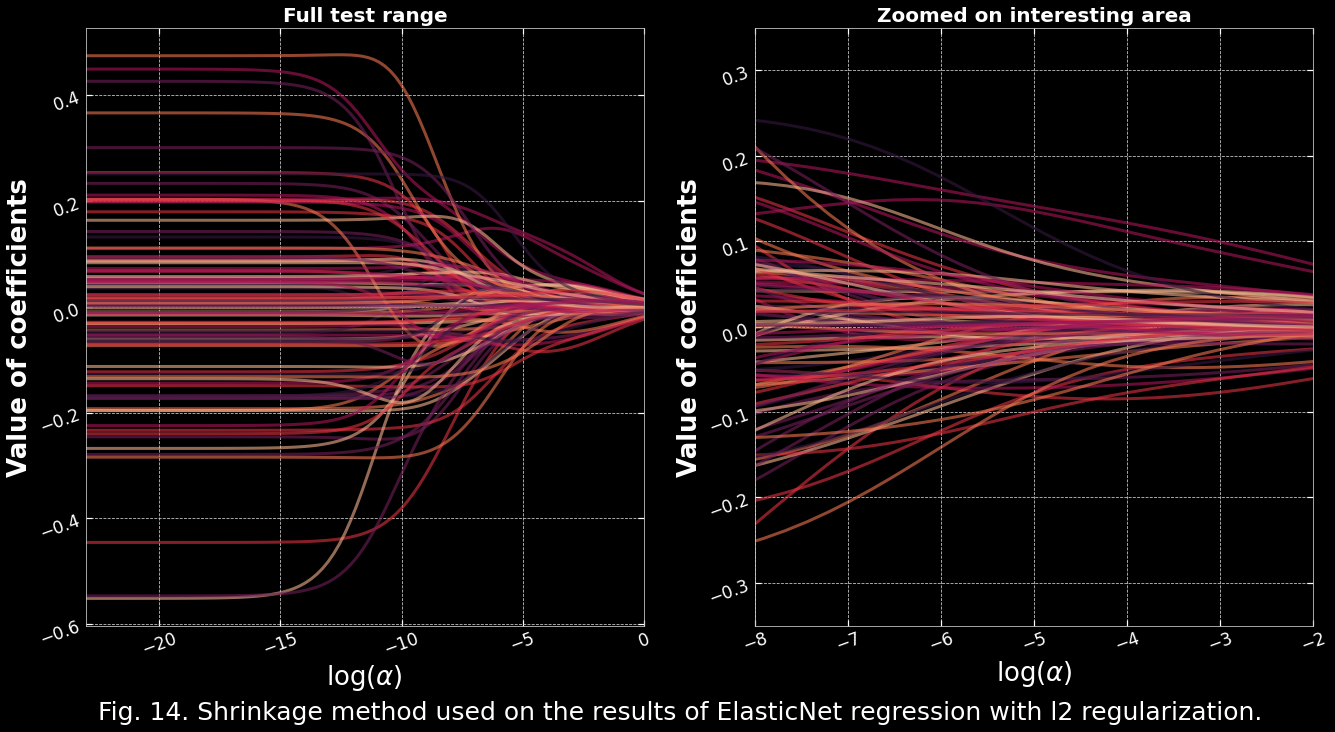

In [413]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*11,nrows*11),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})

ax = axes[0]
ax.set_xlim(np.log(elastic_net_l2_alphas.min()), np.log(elastic_net_l2_alphas.max()))
ax.set_title('Full test range', fontsize=axistitlesize, fontweight='bold', color='white')

ax = axes[1]
ax.set_xlim(-8, -2)
ax.set_ylim(-0.35, 0.35)
ax.set_title('Zoomed on interesting area', fontsize=axistitlesize, fontweight='bold', color='white')

for ax in axes:
    ax.plot(np.log(elastic_net_l2_alphas), elastic_net_l2_coeffs,
          lw=3, alpha=0.6)
    
    ax.set_xlabel('$\log \\left( \\alpha \\right)$', fontsize=axislabelsize, fontweight='bold', color='white')
    ax.set_ylabel('Value of coefficients', fontsize=axislabelsize, fontweight='bold', color='white')
    ax.tick_params(axis='both', which='major', rotation=20, labelsize=axisticksize, colors='white')

fig.suptitle('Fig. 14. Shrinkage method used on the results of ElasticNet regression with l2 regularization.',
             color='white', fontsize=axistitlesize+5, y=0.03)
    
plt.show()

### 5./b. Visualize the optimal penalty surface

In [418]:
from scipy.optimize import minimize

In [419]:
elastic_net_mix_alphas = []
elastic_net_mix_coeffs = []

for a in np.logspace(-10, 10, 100):
    elastic_net_mix_alphas.append(a)
    model = evaluate_elastic_net(X_train, y_train, alpha=a, l1_ratio=0.5, normalize=False, max_iter=1e5)
    elastic_net_mix_coeffs.append(model.coef_)

elastic_net_mix_alphas = np.array(elastic_net_mix_alphas)
elastic_net_mix_coeffs = np.array(elastic_net_mix_coeffs)

In [420]:
# l1_ratio = a + b
# alpha = a / (a + b)
# ==> a = alpha * l1_ratio
# ==> b = l1_ratio - a
a = elastic_net_alphas * 0.5
b = l1_ratio - a

In [425]:
X, Y = np.meshgrid(a, b)
Z = 

### Hints:
 - On total you can get 10 points for fully completing all tasks.
 - Decorate your notebook with, questions, explanation etc, make it self contained and understandable!
 - Comments you code when necessary
 - Write functions for repetitive tasks!
 - Use the pandas package for data loading and handling
 - Use matplotlib and seaborn for plotting or bokeh and plotly for interactive investigation
 - Use the scikit learn package for almost everything
 - Use for loops only if it is really necessary!
 - Code sharing is not allowed between student! Sharing code will result in zero points.
 - If you use code found on web, it is OK, but, make its source clear! 